In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from pathlib import Path
from typing import Any
from logging import INFO, DEBUG
import json
import os
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from scipy.signal import medfilt
from flwr.common import log, ndarrays_to_parameters
import matplotlib.pyplot as plt
import math

from src.common.client_utils import (
    load_femnist_dataset,
    get_network_generator_cnn as get_network_generator,
    get_device,
    get_model_parameters,
    aggregate_weighted_average,
)


from src.flwr_core import (
    set_all_seeds,
    get_paths,
    decompress_dataset,
    get_flower_client_generator,
    sample_random_clients,
    get_federated_evaluation_function,
)

from src.estimate import (
    compute_critical_batch,
)

from src.experiments_simulation import (
    run_simulation,
    centralized_experiment,
)

from src.utils import get_centralized_acc_from_hist

PathType = Path | str | None

**Global variables**

In [2]:
set_all_seeds()

PATHS = get_paths()

HOME_DIR = PATHS["home_dir"]
DATASET_DIR = PATHS["dataset_dir"]
DATA_DIR = PATHS["data_dir"]
CENTRALIZED_PARTITION = PATHS["centralized_partition"]
CENTRALIZED_MAPPING = PATHS["centralized_mapping"]
FEDERATED_PARTITION = PATHS["federated_partition"]

# extract dataset from tar.gz
decompress_dataset(PATHS)

In [3]:
NETWORK_GENERATOR = get_network_generator()
SEED_NET = NETWORK_GENERATOR()
SEED_MODEL_PARAMS = get_model_parameters(SEED_NET)
CID_CLIENT_GENERATOR = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION)

In [4]:
# Centralized experiments
centralized_experiment_batch_sizes = [32, 64, 128, 256, 512, 1024]

# Load the centralized dataset using the same function as in FL.
# The centralized mapping folder should be the one used in the FL centralized experiment.
centralized_train_dataset = load_femnist_dataset(data_dir=DATA_DIR,mapping=CENTRALIZED_MAPPING, name="train")
centralized_test_dataset = load_femnist_dataset(data_dir=DATA_DIR, mapping=CENTRALIZED_MAPPING, name="test")

centralized_train_config = {
    "epochs": 10,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0,
    "num_workers": 0,
    "max_batches": 100,
}

centralized_test_config = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
    "target_accuracy": 0.60,
}

In [5]:
# FL experiments
experiment_batch_sizes = [16, 32, 64, 128, 256]
cohort_sizes = [5, 10, 20, 50, 75, 100]


# Federated configuration dictionary
federated_train_config = {
    "epochs": 10,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0,
    "num_workers": 0,
    "max_batches": 100,
}

federated_test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

num_rounds = 10
num_total_clients = 100
num_evaluate_clients = 0
num_clients_per_round = 10

initial_parameters = ndarrays_to_parameters(SEED_MODEL_PARAMS)

federated_evaluation_function = get_federated_evaluation_function(
    batch_size=federated_test_config["batch_size"],
    num_workers=federated_test_config["num_workers"],
    model_generator=NETWORK_GENERATOR,
    criterion=nn.CrossEntropyLoss(),
    max_batches=None if "max_batches" not in federated_test_config else federated_test_config["max_batches"],
)

server_learning_rate = 1.0
server_momentum = 0.0
accept_failures = False


CID_CLIENT_GENERATOR = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION)

list_of_ids = sample_random_clients(
    num_total_clients, federated_train_config["batch_size"],
    CID_CLIENT_GENERATOR,
)

federated_client_generator = (
    get_flower_client_generator(
        NETWORK_GENERATOR, FEDERATED_PARTITION, lambda seq_id: list_of_ids[seq_id]
    )
)

INFO flwr 2025-03-09 13:57:32,500 | flwr_core.py:105 | cid: 2530
INFO flwr 2025-03-09 13:57:32,584 | flwr_core.py:105 | cid: 2184
INFO flwr 2025-03-09 13:57:32,586 | flwr_core.py:105 | cid: 2907
INFO flwr 2025-03-09 13:57:32,588 | flwr_core.py:105 | cid: 1498
INFO flwr 2025-03-09 13:57:32,589 | flwr_core.py:105 | cid: 2338
INFO flwr 2025-03-09 13:57:32,591 | flwr_core.py:105 | cid: 2399
INFO flwr 2025-03-09 13:57:32,592 | flwr_core.py:105 | cid: 2997
INFO flwr 2025-03-09 13:57:32,593 | flwr_core.py:105 | cid: 678
INFO flwr 2025-03-09 13:57:32,595 | flwr_core.py:105 | cid: 3175
INFO flwr 2025-03-09 13:57:32,596 | flwr_core.py:105 | cid: 1363
INFO flwr 2025-03-09 13:57:32,598 | flwr_core.py:105 | cid: 1571
INFO flwr 2025-03-09 13:57:32,599 | flwr_core.py:105 | cid: 2600
INFO flwr 2025-03-09 13:57:32,600 | flwr_core.py:105 | cid: 1473
INFO flwr 2025-03-09 13:57:32,602 | flwr_core.py:105 | cid: 1260
INFO flwr 2025-03-09 13:57:32,603 | flwr_core.py:105 | cid: 1603
INFO flwr 2025-03-09 13:57

## **Experiments**

### LR scaling

Some rules usually are:

**Linear scaling**

$$ \text{LR} \propto \text{batch size} $$

so, starting with 0.1 at 256, we get then, 0.05 at 128, 0.025 at 64, 0.0125 at 32, 0.00625 at 16.

However, this is not always the case, and it depends on the model, the dataset, the optimizer, etc.

We can also use:

**Sqrt scaling**

$$ \text{LR} \propto \sqrt{\text{batch size}} $$

Starting with 0.1 at 256, we get then, sqrt(128/256) * 0.1 at 128, sqrt(64/256) * 0.1 at 64, sqrt(32/256) * 0.1 at 32, sqrt(16/256) * 0.1 at 16.


Or we can use **Learning Rate Finders**.

***However***, in Federated Learning usually people use lower learning rates.

While in centralized learning its normal to use LR = 0.1 to batch size = 256, in federated learning its usual to use 0.005-0.01 for batch sizes 16-32.


### **Centralized run with varying batch sizes**

In [7]:
centralized_experiment_results = []

for batch_size in centralized_experiment_batch_sizes:

    train_cfg = centralized_train_config.copy()
    train_cfg["batch_size"] = batch_size
    ratio = np.sqrt(batch_size / 256)
    train_cfg["learning_rate"] = ratio * 0.1

    test_cfg = centralized_test_config.copy()
    test_cfg["batch_size"] = batch_size

    # Create DataLoaders with the same settings.
    centralized_train_loader = DataLoader(
        dataset=centralized_train_dataset,
        batch_size=train_cfg["batch_size"],
        shuffle=True,                # Shuffle for training
        num_workers=train_cfg["num_workers"],
        drop_last=True,              # If FL training drops last batch, do the same here.
    )

    centralized_test_loader = DataLoader(
        dataset=centralized_test_dataset,
        batch_size=test_cfg["batch_size"],
        shuffle=False,               # No shuffling during evaluation
        num_workers=test_cfg["num_workers"],
        drop_last=False,
    )
    
    centralized_results = centralized_experiment(centralized_train_config, centralized_test_config, centralized_train_loader, centralized_test_loader, get_device(), NETWORK_GENERATOR())
    centralized_experiment_results.append((batch_size, centralized_results))


INFO flwr 2025-03-08 18:08:45,021 | experiments_simulation.py:132 | Epoch 1/10, Loss: 0.0186, Noise scale: 9.4940e-06, Accuracy: 10.78%, Epoch time: 0.61s
INFO flwr 2025-03-08 18:08:56,160 | experiments_simulation.py:132 | Epoch 2/10, Loss: 0.0157, Noise scale: 3.0784e-05, Accuracy: 25.34%, Epoch time: 0.30s
INFO flwr 2025-03-08 18:09:07,487 | experiments_simulation.py:132 | Epoch 3/10, Loss: 0.0120, Noise scale: 8.4919e-05, Accuracy: 42.19%, Epoch time: 0.28s
INFO flwr 2025-03-08 18:09:17,850 | experiments_simulation.py:132 | Epoch 4/10, Loss: 0.0102, Noise scale: 4.3670e-05, Accuracy: 47.03%, Epoch time: 0.30s
INFO flwr 2025-03-08 18:09:29,234 | experiments_simulation.py:132 | Epoch 5/10, Loss: 0.0086, Noise scale: 4.7254e-05, Accuracy: 51.56%, Epoch time: 0.32s
INFO flwr 2025-03-08 18:09:40,993 | experiments_simulation.py:132 | Epoch 6/10, Loss: 0.0078, Noise scale: 9.0114e-06, Accuracy: 56.50%, Epoch time: 0.32s
INFO flwr 2025-03-08 18:09:51,409 | experiments_simulation.py:132 | Ep

KeyboardInterrupt: 

In [8]:
def load_experiment(save_file_name):
    with open(save_file_name, "r") as f:
        results_dict = json.load(f)
    return results_dict

def save_experiment(save_file_name, results_dict):
    if os.path.exists(save_file_name):
        print(f"File {save_file_name} already exists")
        return
    with open(save_file_name, "w") as f:
        json.dump(results_dict, f, indent=4)

In [8]:
for batch_size, results in centralized_experiment_results:
    save_experiment(f"centralized_experiment_results_{batch_size}.json", results)

Their plot:

Y-axis: $\epsilon_\text{opt}(B) / \epsilon_\text{max}$, which is $\frac{1}{1+\Beta_{noise}/B}$, B batch size, $\Beta_{noise}$ is the noise scale.

X-axis: $\frac{B}{\Beta_{noise}}$, B batch size, $\Beta_{noise}$ is noise scale.

In [ ]:
# Assume centralized_experiment_results is a list of tuples:
# (batch_size, results)
# where results is a dict containing:
#   - "compute_budgets": samples per epoch
#   - "training_time": time per epoch
#   - "noise_scales": list of noise scale values per epoch

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

centralized_experiment_results = [
    (batch_size, load_experiment(f"centralized_experiment_results_{batch_size}.json"))
    for batch_size in centralized_experiment_batch_sizes
]
# Left subplot: Compute Budget vs. Cumulative Training Time for each batch size
for batch_size, results in centralized_experiment_results:
    # Calculate cumulative training time (sum over epochs)
    cumulative_time = np.sum(results["training_time"])
    compute_budget = np.sum(results["compute_cost"])
    axes[0].plot(cumulative_time, compute_budget, marker='o', label=f"Batch size: {batch_size}")
    
    log(INFO, f"Batch size: {batch_size}")
    log(INFO, f"Total Training Time (s): {cumulative_time}")
    log(INFO, f"Compute Budget (samples): {compute_budget}")

axes[0].set_xlabel("Total Training Time (s)")
axes[0].set_ylabel("Compute Budget (Total Samples Processed)")
axes[0].set_title("Compute Budget vs. Total Training Time")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Noise Scale vs. Cumulative Training Time for each batch size
for batch_size, results in centralized_experiment_results:
    noise_scale = np.mean(results["noise_scales"]) # do we average ??

    x_axis = batch_size / noise_scale
    y_axis = 1 / (1 + (noise_scale / batch_size))
    
    axes[1].plot(x_axis, y_axis, marker='o', label=f"Batch size: {batch_size}")
    
    log(INFO, f"Batch size: {batch_size}")
    log(INFO, f"Cumulative Training Time (s): {cumulative_time}")
    log(INFO, f"Noise Scale: {noise_scale}")


axes[1].set_xlabel("Batch Size / Noise Scale")
axes[1].set_ylabel(fr"${{\epsilon_\text{{B}}}} / {{\epsilon_\text{{max}}}}$")
axes[1].set_title("Predicted Training Speed")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


We can also observe that increasing batch size appears does in fact alter performance.

Furthermore, both $\beta_{\text{simple}}$ computation and the empirical results seem to indicate optimal batch sizes with magnitudes in the hundreds (100-1000).

### Critical batch size estimation 

In [9]:
metric_keys = ['training_time', 'samples_processed', 'noise_scale', 'train_loss', 'actual_batches']

In [8]:
import gc

In [ ]:
B_simples = []
results = []
batch_sizes = [16, 32, 64, 128, 256]
for batch_size in batch_sizes:
    train_cfg = federated_train_config.copy()
    train_cfg["batch_size"] = batch_size
    ratio = np.sqrt(batch_size / 256)
    train_cfg["client_learning_rate"] = ratio * 0.01 # Same as centralized, but should be lower for FL

    test_cfg = federated_test_config.copy()
    test_cfg["batch_size"] = batch_size

    local_list_of_ids = sample_random_clients(num_total_clients, train_cfg["batch_size"], CID_CLIENT_GENERATOR)
    local_federated_client_generator = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION, lambda seq_id: local_list_of_ids[seq_id])

    parameters_for_each_round, hist = run_simulation(
        num_rounds = 10,
        num_total_clients = num_total_clients,
        num_clients_per_round = num_clients_per_round,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = num_clients_per_round,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = local_federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        target_accuracy=0.60,
        use_target_accuracy=True
        )
    n_params = len(hist.metrics_distributed_fit.keys()) - 5
    param_keys = list(set(hist.metrics_distributed_fit.keys()) - set(metric_keys))
    hist_metrics = {key: hist.metrics_distributed_fit[key] for key in metric_keys}
    params = [hist.metrics_distributed_fit[key] for key in param_keys]
    del hist
    #gc.collect()

    res = (batch_size, parameters_for_each_round, hist_metrics, params)
    results.append(res)

In [ ]:
import torch
import math

B_simples = [] # 244230
n_clients = 10

K = n_clients
alpha = 0.9

for k, res in enumerate(results):
    batch_size, parameters_for_each_round, hist_metrics, params = res
    B_small = batch_size
    B_big = num_clients_per_round * batch_size
    G_local = params
    n_rounds = len(params[0])
    params_filt = [params[i] for i in range(len(params)) if len(params[i]) == n_rounds]
    G_local_by_rounds = [[params_filt[i][j][1]['all'] for i in range(len(params_filt))] for j in range(n_rounds)]
    B_simples.append([0] * n_rounds)
    for round_idx, G_local in enumerate(G_local_by_rounds):
        G_local = [[el[1] for el in G_loc] for G_loc in G_local]
        G_local_filt = [G_local[i] for i in range(len(G_local)) if len(G_local[i]) == 10]
        G_local_filt = np.array(G_local_filt)
        G_local_filt = G_local_filt.reshape(K, -1)

        G_local_filt = [torch.tensor(G_local) for G_local in G_local_filt]
        
        local_norm_squared = torch.tensor([torch.norm(G_local)**2 for G_local in G_local_filt])

        GBsmall_squared = local_norm_squared.sum() / K

        G_big = sum(G_local_filt) / K

        GBbig_squared = torch.norm(G_big)**2 

        G2 = (1 / (B_big - B_small)) * (B_big * GBbig_squared - B_small * GBsmall_squared) 

        S = (B_small * B_big / (B_big - B_small)) * (GBbig_squared - GBsmall_squared)

        B_simple = S/G2

        B_simples[k][round_idx] = B_simple

B_simples = [[el.item() for el in B_simple] for B_simple in B_simples]
print(B_simples)

In [ ]:
# [[-11687.922491437468, 50476.83433348289, -8360.412075212149, 17319.119343169154, -25954.21660271833, 23370.69120739089, -4962.304179443327, -171059.17398979756], [-19385.786387690354, -48296.90692407105, 14661.483253924791, -13137.487134913083, -78752.06911183994, -43549.34807501476, 33191.38345639109, -8916.155326480151, 26379.271823599152, -17644.262975900085, 56942.85065950044], [63790.0779072847, 18194.037770084386, 20838.652107947135, 67274.89421292844, -313061.2900299799, -271432.3756642664, -63409.341255032, 100693.78565294151, -405953.26435536693, -57494.052391349855, -20407.116358130268], [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], [136404.8146034731, 382788.4590252541, -303602.1198341131, -391914.46840772225, -100359.90833068614, -222389.64401717987, -67227.1535142801, 99115.03185441485, -141411.7204019892, 67098.77896076355, -87909.66401102718, 673764.565140841, -89414.50505702938, -128119.07932215642, -81017.08955323228, 168047.6320547225, -570472.3537002297, -27778430.098110802, 228947.00354616542, -91905.22217824718, -143878.5904577031, 428230.9802809606, -65157.41155478921, -81947.86215890732, -50379.05382373369, -114053.67299065265, -100041.06682634717, -62604.96306232306, -257614.42012444683, -47455.47731560237, 227508.80388985266, 120620.7368087462, -68318.8873917895, -85052.34328022464, 92665.1515040749, -324533.92759395094, -456602.2352201042, -886315.7575465435, 793226.2717526885, 346927.0548617065, -219646.0704645006, 409218.6427205505, 312957.09194129705, -217288.8919829346, -230479.10911932818, -141406.95367459086, 188017.85735417364]]

In [23]:
B_simples =  [[-11687.922491437468, 50476.83433348289, -8360.412075212149, 17319.119343169154, -25954.21660271833, 23370.69120739089, -4962.304179443327, -171059.17398979756], [-19385.786387690354, -48296.90692407105, 14661.483253924791, -13137.487134913083, -78752.06911183994, -43549.34807501476, 33191.38345639109, -8916.155326480151, 26379.271823599152, -17644.262975900085, 56942.85065950044], [63790.0779072847, 18194.037770084386, 20838.652107947135, 67274.89421292844, -313061.2900299799, -271432.3756642664, -63409.341255032, 100693.78565294151, -405953.26435536693, -57494.052391349855, -20407.116358130268], [0,0,0,0,0], [136404.8146034731, 382788.4590252541, -303602.1198341131, -391914.46840772225, -100359.90833068614, -222389.64401717987, -67227.1535142801, 99115.03185441485, -141411.7204019892, 67098.77896076355, -87909.66401102718, 673764.565140841, -89414.50505702938, -128119.07932215642, -81017.08955323228, 168047.6320547225, -570472.3537002297, -27778430.098110802, 228947.00354616542, -91905.22217824718, -143878.5904577031, 428230.9802809606, -65157.41155478921, -81947.86215890732, -50379.05382373369, -114053.67299065265, -100041.06682634717, -62604.96306232306, -257614.42012444683, -47455.47731560237, 227508.80388985266, 120620.7368087462, -68318.8873917895, -85052.34328022464, 92665.1515040749, -324533.92759395094, -456602.2352201042, -886315.7575465435, 793226.2717526885, 346927.0548617065, -219646.0704645006, 409218.6427205505, 312957.09194129705, -217288.8919829346, -230479.10911932818, -141406.95367459086, 188017.85735417364]]
B_simples = [[abs(el) for el in subl] for subl in B_simples]
# apply median filter for each sublist
B_simple_median = [medfilt(subl, 5) for subl in B_simples]

In [ ]:
# plot nicely B_simple through the rounds
fig, ax = plt.subplots(figsize=(10, 5))
for bs, B_sim in zip(batch_sizes, B_simple_median):
    ax.plot(B_sim, label=f"Batch size: {bs}")
ax.set_xlabel('Round')
ax.set_ylabel('Batch Size')
ax.set_title('Critical Batch Size through Rounds')
ax.legend()
# log scale y
ax.set_yscale('log')
#ax.set_ylim(0, 5000)
plt.grid(True)
plt.show()



### **FL run with varying batch sizes**

In [ ]:
total_batch_results = []

for batch_size in experiment_batch_sizes:
    train_cfg = federated_train_config.copy()
    train_cfg["batch_size"] = batch_size
    ratio = np.sqrt(batch_size / 256)
    train_cfg["client_learning_rate"] = ratio * 0.01 # Same as centralized, but should be lower for FL

    test_cfg = federated_test_config.copy()
    test_cfg["batch_size"] = batch_size

    local_list_of_ids = sample_random_clients(num_total_clients, train_cfg["batch_size"], CID_CLIENT_GENERATOR)
    local_federated_client_generator = get_flower_client_generator(NETWORK_GENERATOR, FEDERATED_PARTITION, lambda seq_id: local_list_of_ids[seq_id])

    parameters_for_each_round, hist = run_simulation(
        num_rounds = num_rounds,
        num_total_clients = num_total_clients,
        num_clients_per_round = num_clients_per_round,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = num_clients_per_round,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = local_federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        target_accuracy=0.60,
        use_target_accuracy=True,
        )

    total_batch_results.append((batch_size, parameters_for_each_round, hist))

In [7]:
import pickle

def save_experiment(save_file_name, batch_size, parameters_for_each_round, hist):
    """Save experiment results using pickle.
    
    Args:
        save_file_name (str): Path to save the results
        batch_size (int): Batch size used in experiment
        parameters_for_each_round (list): List of model parameters for each round
        hist (History): Flower History object containing metrics
    """
    
    results_dict = {
        'batch_size': batch_size,
        'parameters_for_each_round': parameters_for_each_round,
        'history': hist
    }
    
    with open(save_file_name, 'wb') as f:  # Note: 'wb' for binary write mode
        pickle.dump(results_dict, f)

def load_experiment(file_name):
    """Load experiment results from a pickle file.
    
    Args:
        file_name (str): Path to the results file
        
    Returns:
        tuple: (batch_size, parameters_for_each_round, hist)
    """
    with open(file_name, 'rb') as f:  # Note: 'rb' for binary read mode
        results_dict = pickle.load(f)
    
    return (
        results_dict['batch_size'],
        results_dict['parameters_for_each_round'],
        results_dict['history'],
    )

In [10]:

for batch_size, parameters, hist in total_batch_results:
    save_experiment(f"federated_batch_results_{batch_size}.pkl", batch_size, parameters, hist)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Bottom-left: Compute Budget vs Training Time
for batch_size, params, hist in total_batch_results:
    times = []
    samples = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['training_time']:
        round_times = [t for _, t in round_metrics['all']]
        times.append(np.mean(round_times))
        
    for round_idx, round_metrics in hist.metrics_distributed_fit['samples_processed']:
        round_samples = [s for _, s in round_metrics['all']]
        samples.append(np.sum(round_samples))
    
    cumulative_time = np.sum(times)
    total_samples = np.sum(samples)
    axes[0].plot(cumulative_time, total_samples, marker='o', label=f"Local batch size: {batch_size}")

axes[0].set_xlabel("Total Training Time (s)")
axes[0].set_ylabel("Compute Budget (Total Samples Processed)")
axes[0].set_title("Compute Budget vs. Total Training Time")
axes[0].legend()
axes[0].grid(True)

# Bottom-right: Noise Scale Analysis
for batch_size, params, hist in total_batch_results:
    noise_scales = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['noise_scale']:
        round_noise_scales = [ns for _, ns in round_metrics['all']]
        noise_scale = np.mean(round_noise_scales)
        noise_scales.append(noise_scale)
    
    avg_noise_scale = np.mean(noise_scales)
    x_axis = batch_size / (avg_noise_scale + 1e-10)
    y_axis = 1 / (1 + (avg_noise_scale / batch_size))
    
    axes[1].plot(x_axis, y_axis, marker='o', label=f"Batch size: {batch_size}")

axes[1].set_xlabel("Batch Size / Noise Scale")
axes[1].set_ylabel(fr"${{\epsilon_\text{{B}}}} / {{\epsilon_\text{{max}}}}$")
axes[1].set_title("Predicted Training Speed")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
for batch_size, params, hist in total_batch_results:
    print("Batch size: ", batch_size)

    noise_scales = hist.metrics_distributed_fit['noise_scale']

    crit_batches = []
    for round, round_noise_scales in noise_scales:
        actual_noise_scales = [val for _, val in round_noise_scales['all']]
        crit_batch = compute_critical_batch(actual_noise_scales, .001)
        print("---", crit_batch)
        crit_batches.append(crit_batch)
    print(np.mean(crit_batches)) 

When running FL experiments with multiple batch sizes, we do observe that there must be something as "critical" batch size.

However, we must investigate how to identify it.

## **Running FL with varying cohort sizes**

### Calculating average time per round

Since Flower is simulating multiple clients using multiple threads, a problem appears where the time we measure in multi-client setup is influenced by the context switching between threads and the waiting time.

Therefore, we derive an assumption that the time per round is constant when we fix a batch size (which we do in this experiment).

In [6]:
cohort_size = 2
train_cfg = federated_train_config.copy()
ratio = np.sqrt(cohort_size / 100)
train_cfg["client_learning_rate"] = ratio * 0.01
#train_cfg["max_batches"] = 1000

test_cfg = federated_test_config.copy()

parameters_for_each_round, hist = run_simulation(
    num_rounds = 1,
    num_total_clients = num_total_clients,
    num_clients_per_round = cohort_size,
    num_evaluate_clients = num_evaluate_clients,
    min_available_clients = num_total_clients,
    min_fit_clients = cohort_size,
    min_evaluate_clients = num_evaluate_clients,
    evaluate_fn = federated_evaluation_function,
    on_fit_config_fn = lambda _: train_cfg,
    on_evaluate_config_fn = lambda _: test_cfg,
    initial_parameters = initial_parameters,
    fit_metrics_aggregation_fn = aggregate_weighted_average,
    evaluate_metrics_aggregation_fn = aggregate_weighted_average,
    federated_client_generator = federated_client_generator,
    server_learning_rate=server_learning_rate,
    server_momentum=server_momentum,
    accept_failures=accept_failures,
    target_accuracy=0.60,
    use_target_accuracy=True,
    )





INFO flwr 2025-03-09 13:57:43,895 | experiments_simulation.py:200 | FL will execute for 1 rounds
WARNING flwr 2025-03-09 13:57:43,899 | app.py:213 | Both server and strategy were provided, ignoring strategy
INFO flwr 2025-03-09 13:57:43,899 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2025-03-09 13:57:43,900 | flwr_core.py:262 | Initializing global parameters
INFO flwr 2025-03-09 13:57:43,900 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-03-09 13:57:43,901 | flwr_core.py:267 | Evaluating initial parameters
 11%|█         | 100/891 [00:02<00:19, 40.25it/s]
INFO flwr 2025-03-09 13:57:46,603 | flwr_core.py:270 | initial parameters (loss, other metrics): 413.68430757522583, {'accuracy': 0.0065625}
INFO flwr 2025-03-09 13:57:46,603 | flwr_core.py:278 | FL starting - Target accuracy: 0.6
DEBUG flwr 2025-03-09 13:57:46,604 | server_returns_parameters.py:223 | fit_round 1: strateg

In [8]:
avg_times_per_round = []
for (round_idx, round_metrics), metrics_acc in zip(hist.metrics_distributed_fit['training_time'], hist.metrics_centralized['accuracy']):
    round_times = [t for _, t in round_metrics['all']]
    avg_time_per_round = np.mean(round_times)    
    avg_times_per_round.append(avg_time_per_round)

time_per_round = np.median(avg_times_per_round)
print(time_per_round) # 0.00427

0.004272393967856994


In [13]:
import pickle

def save_experiment(save_file_name, batch_size, parameters_for_each_round, hist):
    """Save experiment results using pickle.
    
    Args:
        save_file_name (str): Path to save the results
        batch_size (int): Batch size used in experiment
        parameters_for_each_round (list): List of model parameters for each round
        hist (History): Flower History object containing metrics
    """
    
    results_dict = {
        'batch_size': batch_size,
        'parameters_for_each_round': parameters_for_each_round,
        'history': hist
    }
    
    with open(save_file_name, 'wb') as f:  # Note: 'wb' for binary write mode
        pickle.dump(results_dict, f)

def load_experiment(file_name):
    """Load experiment results from a pickle file.
    
    Args:
        file_name (str): Path to the results file
        
    Returns:
        tuple: (batch_size, parameters_for_each_round, hist)
    """
    with open(file_name, 'rb') as f:  # Note: 'rb' for binary read mode
        results_dict = pickle.load(f)
    
    return (
        results_dict['batch_size'],
        results_dict['parameters_for_each_round'],
        results_dict['history'],
    )

total_cohort_results = []
cohort_sizes =  [ 5, 10, 20, 50, 75, 100]
for cohort_size in cohort_sizes:
    train_cfg = federated_train_config.copy()
    ratio = np.sqrt(cohort_size / 100)
    train_cfg["client_learning_rate"] = ratio * 0.01
    #train_cfg["max_batches"] = 1000

    test_cfg = federated_test_config.copy()

    parameters_for_each_round, hist = run_simulation(
        num_rounds = 100,
        num_total_clients = num_total_clients,
        num_clients_per_round = cohort_size,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = cohort_size,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        target_accuracy=0.60,
        use_target_accuracy=True,
        )

    total_cohort_results.append((cohort_size, parameters_for_each_round, hist))
    save_experiment(f"recent_correct_exps/federated_cohort_results1_{cohort_size}.pkl", cohort_size, parameters_for_each_round=parameters_for_each_round, hist=hist)

INFO flwr 2025-03-08 18:13:17,425 | experiments_simulation.py:200 | FL will execute for 100 rounds
WARNING flwr 2025-03-08 18:13:17,427 | app.py:213 | Both server and strategy were provided, ignoring strategy
INFO flwr 2025-03-08 18:13:17,428 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
INFO flwr 2025-03-08 18:13:17,429 | flwr_core.py:262 | Initializing global parameters
INFO flwr 2025-03-08 18:13:17,430 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-03-08 18:13:17,432 | flwr_core.py:267 | Evaluating initial parameters
 11%|█         | 100/891 [00:02<00:22, 34.70it/s]
INFO flwr 2025-03-08 18:13:20,335 | flwr_core.py:270 | initial parameters (loss, other metrics): 413.68430757522583, {'accuracy': 0.0065625}
INFO flwr 2025-03-08 18:13:20,336 | flwr_core.py:278 | FL starting - Target accuracy: 0.6
DEBUG flwr 2025-03-08 18:13:20,337 | server_returns_parameters.py:223 | fit_round 1: str

In [ ]:
for cohort_size, parameters, hist in total_cohort_results:
    save_experiment(f"recent_correct_exps/federated_cohort_results1_{cohort_size}.pkl", cohort_size, parameters_for_each_round=parameters, hist=hist)

In [9]:
cohort_sizes =  [5, 10, 20, 50, 75, 100]
total_cohort_results = []
for cohort_size in cohort_sizes:
    total_cohort_results.append(load_experiment(f"recent_correct_exps/federated_cohort_results_{cohort_size}.pkl"))

NameError: name 'load_experiment' is not defined

In [14]:
for cohort_size, params, hist in total_cohort_results:
    print(f"COHORT SIZE: {cohort_size}")
    print("--------------------------------")
    for (round_idx, round_metrics), metrics_acc in zip(hist.metrics_distributed_fit['training_time'], hist.metrics_centralized['accuracy']):
        round_times = [t for _, t in round_metrics['all']]
        print(f"ROUND {round_idx}")
        print(f"TRAINING TIME: {round_times}, ACC: {metrics_acc}")

COHORT SIZE: 5
--------------------------------
ROUND 1
TRAINING TIME: [0.012056456187500508, 0.015556916850001911, 0.014747466771429175, 0.012633667487500588, 0.01724801722500082], ACC: (0, 0.0065625)
ROUND 2
TRAINING TIME: [0.014630600074999833, 0.013652523539999208, 0.014689323519999676, 0.009278644409090476, 0.011217456687499627], ACC: (1, 0.071875)
ROUND 3
TRAINING TIME: [0.008859705570000216, 0.009859681662500818, 0.011342206050001025, 0.010276004357144635, 0.012205814574997831], ACC: (2, 0.2296875)
ROUND 4
TRAINING TIME: [0.013548282399999324, 0.014089665959999139, 0.014686241424999835, 0.014956046700000059, 0.012734475940000038], ACC: (3, 0.3215625)
ROUND 5
TRAINING TIME: [0.008955925112501184, 0.013864188699999502, 0.012886068000000606, 0.008223866079999738, 0.013050282300000049], ACC: (4, 0.4178125)
ROUND 6
TRAINING TIME: [0.01136419533999856, 0.012584200174999793, 0.012242634259999932, 0.014125950949999933, 0.012274582224999974], ACC: (5, 0.3778125)
ROUND 7
TRAINING TIME: [0

22
13
7
6
7
7


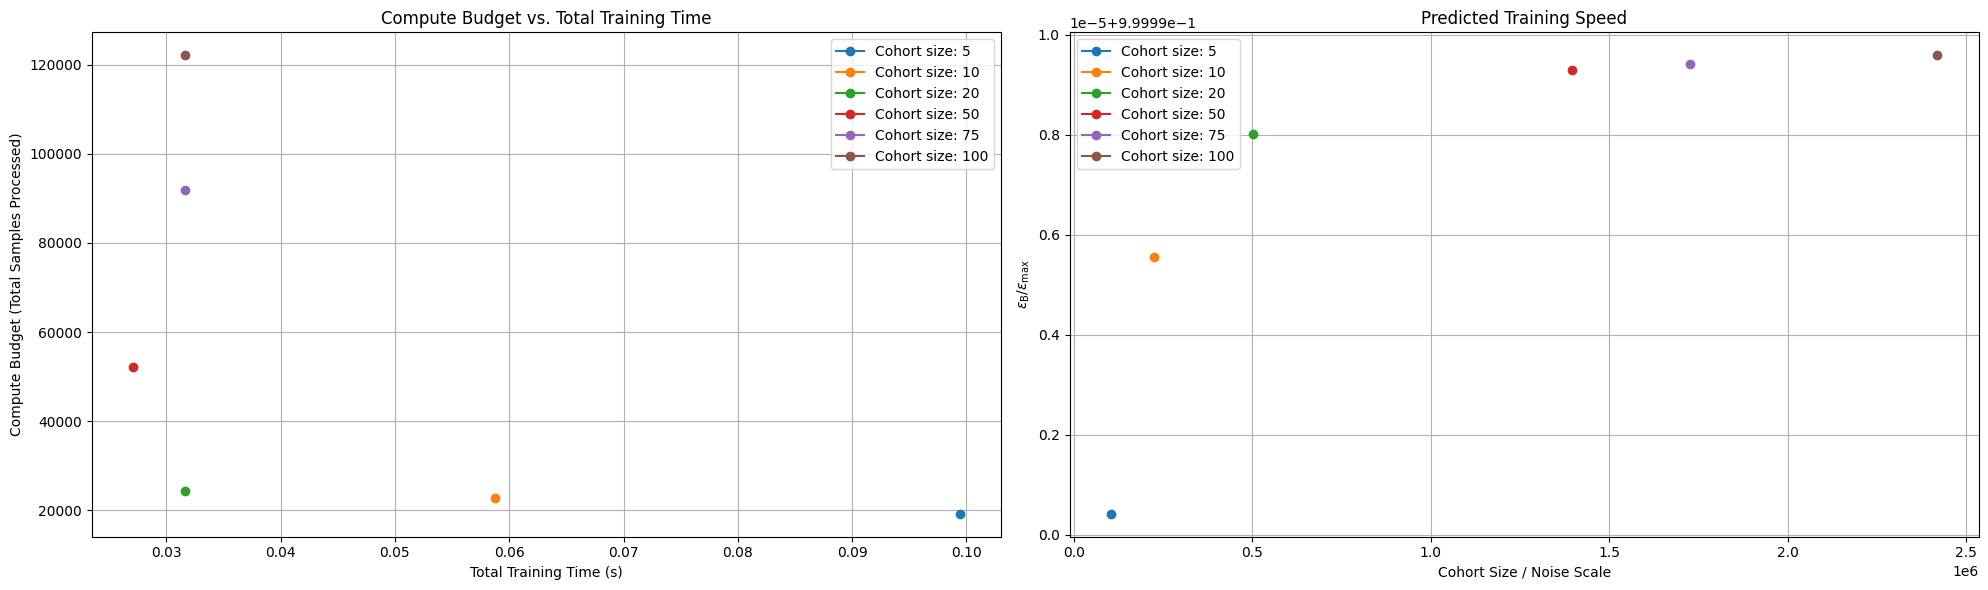

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Bottom-left: Compute Budget vs Training Time
for cohort_size, params, hist in total_cohort_results:
    times = []
    samples = []
    num_rounds = len(hist.metrics_distributed_fit['samples_processed'])
    print(num_rounds)
    cumulative_time = num_rounds * time_per_round

    for round_idx, round_metrics in hist.metrics_distributed_fit['samples_processed']:
        round_samples = [s for _, s in round_metrics['all']]
        samples.append(np.sum(round_samples))
    
    
    total_samples = np.sum(samples)
    axes[0].plot(cumulative_time, total_samples, marker='o', label=f"Cohort size: {cohort_size}")

axes[0].set_xlabel("Total Training Time (s)")
axes[0].set_ylabel("Compute Budget (Total Samples Processed)")
axes[0].set_title("Compute Budget vs. Total Training Time")
axes[0].legend()
axes[0].grid(True)

# Bottom-right: Noise Scale Analysis
for cohort_size, params, hist in total_cohort_results:
    noise_scales = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['noise_scale']:
        round_noise_scales = [ns for _, ns in round_metrics['all']]
        noise_scale = np.mean(round_noise_scales)
        noise_scales.append(noise_scale)
    
    avg_noise_scale = np.mean(noise_scales)
    x_axis = cohort_size / (avg_noise_scale + 1e-10)
    y_axis = 1 / (1 + (avg_noise_scale / cohort_size))
    
    axes[1].plot(x_axis, y_axis, marker='o', label=f"Cohort size: {cohort_size}")

axes[1].set_xlabel("Cohort Size / Noise Scale")
axes[1].set_ylabel(fr"${{\epsilon_\text{{B}}}} / {{\epsilon_\text{{max}}}}$")
axes[1].set_title("Predicted Training Speed")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Global batch size vs time per round

In [ ]:
#16 - 256
# 5 - 100


# 80 - 25000

# 100 = 20bs * 5c
# 1000 = 50bs * 20cs
# 10000 = 200bs * 50cs
# 25000 = 250bs * 100cs

In [10]:
times_per_round = []
for batch_size in [20, 50, 200, 250]:
    cohort_size = 2
    train_cfg = federated_train_config.copy()
    ratio = np.sqrt(cohort_size / 100)
    train_cfg["client_learning_rate"] = ratio * 0.01
    #train_cfg["max_batches"] = 1000

    test_cfg = federated_test_config.copy()

    parameters_for_each_round, hist = run_simulation(
        num_rounds = 1,
        num_total_clients = num_total_clients,
        num_clients_per_round = cohort_size,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = cohort_size,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        target_accuracy=0.60,
        use_target_accuracy=True,
        )

    avg_times_per_round = []
    for (round_idx, round_metrics), metrics_acc in zip(hist.metrics_distributed_fit['training_time'], hist.metrics_centralized['accuracy']):
        round_times = [t for _, t in round_metrics['all']]
        avg_time_per_round = np.mean(round_times)    
        avg_times_per_round.append(avg_time_per_round)

    time_per_round = np.median(avg_times_per_round)
    print(time_per_round) # 0.00427
    times_per_round.append(time_per_round)

print(times_per_round) # [0.003793160191070807, 0.004481774148126263, 0.004956590107499679, 0.004278853300000662]

INFO flwr 2025-03-09 14:44:04,718 | experiments_simulation.py:200 | FL will execute for 1 rounds
WARNING flwr 2025-03-09 14:44:04,721 | app.py:213 | Both server and strategy were provided, ignoring strategy
INFO flwr 2025-03-09 14:44:04,721 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=1, round_timeout=None)
INFO flwr 2025-03-09 14:44:04,722 | flwr_core.py:262 | Initializing global parameters
INFO flwr 2025-03-09 14:44:04,725 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-03-09 14:44:04,726 | flwr_core.py:267 | Evaluating initial parameters
 11%|█         | 100/891 [00:01<00:11, 67.57it/s]
INFO flwr 2025-03-09 14:44:06,224 | flwr_core.py:270 | initial parameters (loss, other metrics): 413.68430757522583, {'accuracy': 0.0065625}
INFO flwr 2025-03-09 14:44:06,225 | flwr_core.py:278 | FL starting - Target accuracy: 0.6
DEBUG flwr 2025-03-09 14:44:06,226 | server_returns_parameters.py:223 | fit_round 1: strateg

0.003793160191070807


 11%|█         | 100/891 [00:00<00:07, 111.24it/s]
INFO flwr 2025-03-09 14:45:31,024 | flwr_core.py:270 | initial parameters (loss, other metrics): 413.68430757522583, {'accuracy': 0.0065625}
INFO flwr 2025-03-09 14:45:31,025 | flwr_core.py:278 | FL starting - Target accuracy: 0.6
DEBUG flwr 2025-03-09 14:45:31,025 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 2 clients (out of 100)
INFO flwr 2025-03-09 14:45:31,026 | flwr_core.py:105 | cid: 937
INFO flwr 2025-03-09 14:45:31,027 | flwr_core.py:105 | cid: 1167
DEBUG flwr 2025-03-09 14:45:32,795 | server_returns_parameters.py:237 | fit_round 1 received 2 results and 0 failures
 11%|█         | 100/891 [00:00<00:06, 127.25it/s]
INFO flwr 2025-03-09 14:45:33,605 | flwr_core.py:301 | fit progress: (round 1, accuracy 0.0059375, loss 379.70548963546753, time 2.579693193983985)
INFO flwr 2025-03-09 14:45:33,606 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel
DEBUG flwr 2025-03-09 14:45:33

0.004481774148126263


 11%|█         | 100/891 [00:00<00:07, 111.39it/s]
INFO flwr 2025-03-09 14:47:13,670 | flwr_core.py:270 | initial parameters (loss, other metrics): 413.68430757522583, {'accuracy': 0.0065625}
INFO flwr 2025-03-09 14:47:13,670 | flwr_core.py:278 | FL starting - Target accuracy: 0.6
DEBUG flwr 2025-03-09 14:47:13,671 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 2 clients (out of 100)
INFO flwr 2025-03-09 14:47:13,672 | flwr_core.py:105 | cid: 937
INFO flwr 2025-03-09 14:47:13,673 | flwr_core.py:105 | cid: 1167
DEBUG flwr 2025-03-09 14:47:15,427 | server_returns_parameters.py:237 | fit_round 1 received 2 results and 0 failures
 11%|█         | 100/891 [00:00<00:07, 103.08it/s]
INFO flwr 2025-03-09 14:47:16,423 | flwr_core.py:301 | fit progress: (round 1, accuracy 0.0059375, loss 381.78136110305786, time 2.7522129459830467)
INFO flwr 2025-03-09 14:47:16,424 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel
DEBUG flwr 2025-03-09 14:47:1

0.004956590107499679


 11%|█         | 100/891 [00:00<00:06, 120.11it/s]
INFO flwr 2025-03-09 14:48:23,100 | flwr_core.py:270 | initial parameters (loss, other metrics): 413.68430757522583, {'accuracy': 0.0065625}
INFO flwr 2025-03-09 14:48:23,100 | flwr_core.py:278 | FL starting - Target accuracy: 0.6
DEBUG flwr 2025-03-09 14:48:23,100 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 2 clients (out of 100)
INFO flwr 2025-03-09 14:48:23,101 | flwr_core.py:105 | cid: 937
INFO flwr 2025-03-09 14:48:23,103 | flwr_core.py:105 | cid: 1167
DEBUG flwr 2025-03-09 14:48:24,737 | server_returns_parameters.py:237 | fit_round 1 received 2 results and 0 failures
 11%|█         | 100/891 [00:00<00:06, 119.69it/s]
INFO flwr 2025-03-09 14:48:25,598 | flwr_core.py:301 | fit progress: (round 1, accuracy 0.0059375, loss 380.27868843078613, time 2.497332450991962)
INFO flwr 2025-03-09 14:48:25,599 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel
DEBUG flwr 2025-03-09 14:48:25

0.004278853300000662
[0.003793160191070807, 0.004481774148126263, 0.004956590107499679, 0.004278853300000662]


In [11]:
import pickle

def save_experiment(save_file_name, batch_size, parameters_for_each_round, hist):
    """Save experiment results using pickle.
    
    Args:
        save_file_name (str): Path to save the results
        batch_size (int): Batch size used in experiment
        parameters_for_each_round (list): List of model parameters for each round
        hist (History): Flower History object containing metrics
    """
    
    results_dict = {
        'batch_size': batch_size,
        'parameters_for_each_round': parameters_for_each_round,
        'history': hist
    }
    
    with open(save_file_name, 'wb') as f:  # Note: 'wb' for binary write mode
        pickle.dump(results_dict, f)

def load_experiment(file_name):
    """Load experiment results from a pickle file.
    
    Args:
        file_name (str): Path to the results file
        
    Returns:
        tuple: (batch_size, parameters_for_each_round, hist)
    """
    with open(file_name, 'rb') as f:  # Note: 'rb' for binary read mode
        results_dict = pickle.load(f)
    
    return (
        results_dict['batch_size'],
        results_dict['parameters_for_each_round'],
        results_dict['history'],
    )

total_global_batch_results = []
cs_bs_pairs = [(5, 20), (20, 50), (50, 200), (100, 250)]
for cohort_size, batch_size in cs_bs_pairs:
    global_batch_size = batch_size * cohort_size
    train_cfg = federated_train_config.copy()
    ratio = np.sqrt(cohort_size / 100)
    train_cfg["client_learning_rate"] = ratio * 0.01
    #train_cfg["max_batches"] = 1000

    test_cfg = federated_test_config.copy()

    parameters_for_each_round, hist = run_simulation(
        num_rounds = 100,
        num_total_clients = num_total_clients,
        num_clients_per_round = cohort_size,
        num_evaluate_clients = num_evaluate_clients,
        min_available_clients = num_total_clients,
        min_fit_clients = cohort_size,
        min_evaluate_clients = num_evaluate_clients,
        evaluate_fn = federated_evaluation_function,
        on_fit_config_fn = lambda _: train_cfg,
        on_evaluate_config_fn = lambda _: test_cfg,
        initial_parameters = initial_parameters,
        fit_metrics_aggregation_fn = aggregate_weighted_average,
        evaluate_metrics_aggregation_fn = aggregate_weighted_average,
        federated_client_generator = federated_client_generator,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        accept_failures=accept_failures,
        target_accuracy=0.60,
        use_target_accuracy=True,
        )

    total_global_batch_results.append((global_batch_size, parameters_for_each_round, hist))
    save_experiment(f"recent_correct_exps/federated_global_batch_results_{global_batch_size}.pkl", global_batch_size, parameters_for_each_round=parameters_for_each_round, hist=hist)

INFO flwr 2025-03-09 14:53:27,281 | experiments_simulation.py:200 | FL will execute for 100 rounds
WARNING flwr 2025-03-09 14:53:27,282 | app.py:213 | Both server and strategy were provided, ignoring strategy
INFO flwr 2025-03-09 14:53:27,283 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
INFO flwr 2025-03-09 14:53:27,285 | flwr_core.py:262 | Initializing global parameters
INFO flwr 2025-03-09 14:53:27,286 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2025-03-09 14:53:27,288 | flwr_core.py:267 | Evaluating initial parameters
 11%|█         | 100/891 [00:01<00:12, 62.83it/s]
INFO flwr 2025-03-09 14:53:28,904 | flwr_core.py:270 | initial parameters (loss, other metrics): 413.68430757522583, {'accuracy': 0.0065625}
INFO flwr 2025-03-09 14:53:28,905 | flwr_core.py:278 | FL starting - Target accuracy: 0.6
DEBUG flwr 2025-03-09 14:53:28,906 | server_returns_parameters.py:223 | fit_round 1: str

15
10
9
7


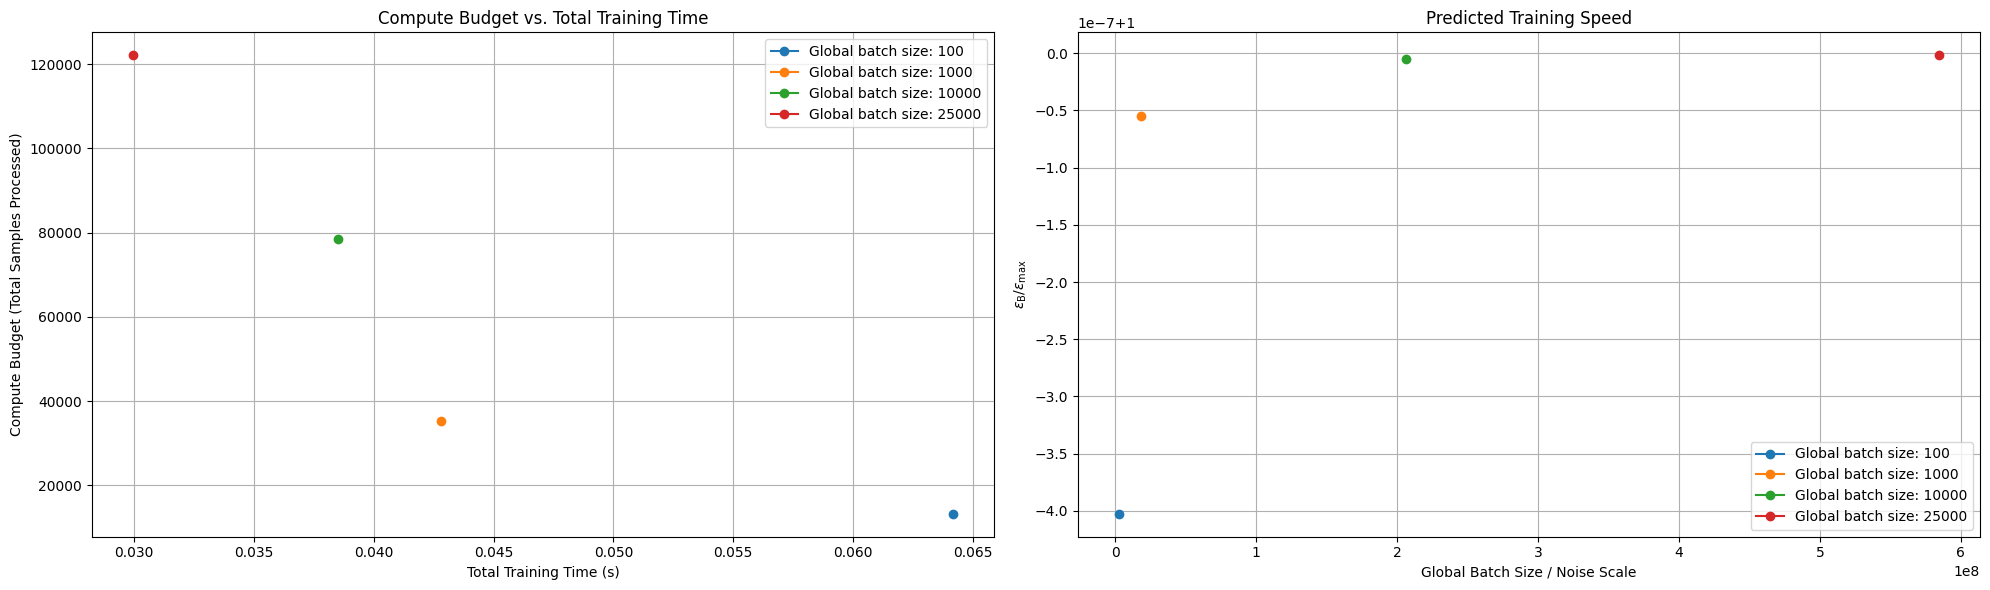

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Bottom-left: Compute Budget vs Training Time
for global_batch_size, params, hist in total_global_batch_results:
    times = []
    samples = []
    num_rounds = len(hist.metrics_distributed_fit['samples_processed'])
    print(num_rounds)
    cumulative_time = num_rounds * time_per_round

    for round_idx, round_metrics in hist.metrics_distributed_fit['samples_processed']:
        round_samples = [s for _, s in round_metrics['all']]
        samples.append(np.sum(round_samples))
    
    
    total_samples = np.sum(samples)
    axes[0].plot(cumulative_time, total_samples, marker='o', label=f"Global batch size: {global_batch_size}")

axes[0].set_xlabel("Total Training Time (s)")
axes[0].set_ylabel("Compute Budget (Total Samples Processed)")
axes[0].set_title("Compute Budget vs. Total Training Time")
axes[0].legend()
axes[0].grid(True)

# Bottom-right: Noise Scale Analysis
for global_batch_size, params, hist in total_global_batch_results:
    noise_scales = []
    for round_idx, round_metrics in hist.metrics_distributed_fit['noise_scale']:
        round_noise_scales = [ns for _, ns in round_metrics['all']]
        noise_scale = np.mean(round_noise_scales)
        noise_scales.append(noise_scale)
    
    avg_noise_scale = np.mean(noise_scales)
    x_axis = global_batch_size / (avg_noise_scale + 1e-10)
    y_axis = 1 / (1 + (avg_noise_scale / global_batch_size))
    
    axes[1].plot(x_axis, y_axis, marker='o', label=f"Global batch size: {global_batch_size}")

axes[1].set_xlabel("Global Batch Size / Noise Scale")
axes[1].set_ylabel(fr"${{\epsilon_\text{{B}}}} / {{\epsilon_\text{{max}}}}$")
axes[1].set_title("Predicted Training Speed")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()